#### The dataset includes users who hit an ecommerce site. The goal is to come up with insights and recommendations for the product and the marketing to improve conversion rate 

In [5]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
path = os.getcwd()

In [7]:
data = pd.read_csv(path+'/conversion_project.csv')

In [8]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


## Explore the data

In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [7]:
data.groupby(['country']).count()

,age,new_user,source,total_pages_visited,converted
country,,,,,
China,76602,76602,76602,76602,76602
Germany,13056,13056,13056,13056,13056
UK,48450,48450,48450,48450,48450
US,178092,178092,178092,178092,178092


In [8]:
## look at age column
print(sorted(data['age'].unique()))

[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 77, 79, 111, 123]


In [9]:
data[data['age']>110]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


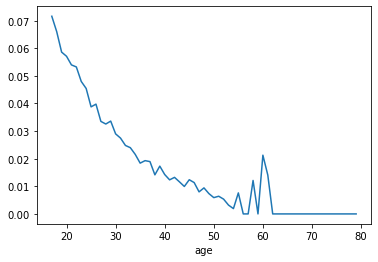

In [12]:
data.groupby(['age'])['converted'].mean().plot()

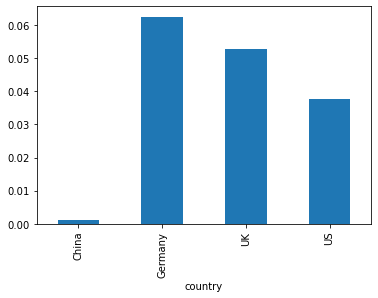

In [11]:
data.groupby(['country'])['converted'].mean().plot.bar()

In [9]:
data = data[data['age']<110]

Text(0.5, 1.0, 'new user count base on country')

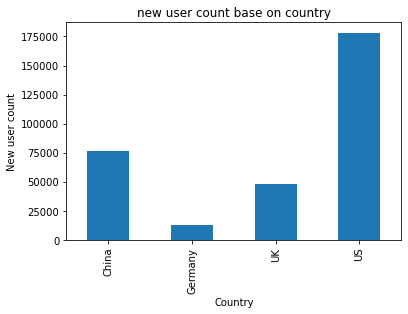

In [11]:

data.groupby(['country'])['new_user'].count().plot.bar()
plt.xlabel('Country')
plt.ylabel('New user count')
plt.title('new user count base on country')

In [12]:
data.groupby(['source']).count()

,country,age,new_user,total_pages_visited,converted
source,,,,,
Ads,88739,88739,88739,88739,88739
Direct,72420,72420,72420,72420,72420
Seo,155039,155039,155039,155039,155039


###### A few quick observations:
##### this site is a US site which has a large Chinese user base 
##### user base is quite young
##### conversion rate is around 3%
##### here might be  an outlier in gage ocolum because we have people who aged 123

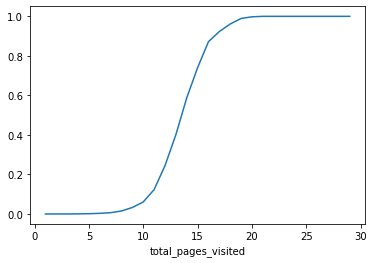

In [13]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()

###### spending more time on the site implies higher probability of conversion

## Machine Learning

###### build a model to predict conversion rate. we are trying to find insights to give product and marketing team project ideas.

In [14]:
### I pick  random forest to predict conversion rate because it usually requires very little time to
##optimize it and it is strong with outliers, irrelevant variables, continuous and discrete variables.
## Then I will use use its partial dependence plots and variable importance to get insights. Also, 
##I will build a simple tree to find the most obvious user segments.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(101)

In [16]:
#dummy variables for the categorical ones
data_dummy = pd.get_dummies(data, drop_first=True)

In [17]:
## split the data
train, test = train_test_split(data_dummy, test_size = 0.34)

## build the model
rf =  RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted',axis=1), train['converted'])

##print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9841918635296373 
 OOB Confusion Matrix 
         0     1
0  200824  1094
1    2205  4567


In [18]:
##print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('converted', axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9849313539457528 
 Test Set Confusion Matrix 
         0     1
0  103551   531
1    1089  2337


In [19]:
(548+1105)/(103495+548+1105+2360)

0.01537559995535216

###### OOB error and test error are similar ~1.5% so we are not overfitting, and now I would like to check variable importance

In [20]:
feat_importance = pd.Series(rf.feature_importances_, index = train.drop('converted',axis=1).columns)

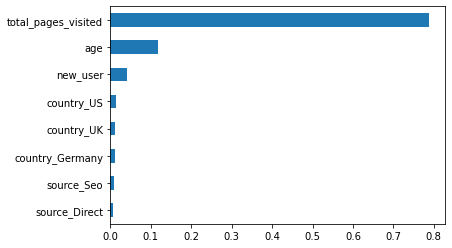

In [21]:
feat_importance.sort_values().plot.barh()

In [22]:
##  total_page_visited is the most important one but is  the least actionable one, so I would like to build 
## RF without that variable. Since classes are heacily unbalanced and I'll change the weights, just to make sure 
## wew will get something classified as 1


In [23]:
#build the model withouth  total_page_visited

rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.8915664382577028 
 OOB Confusion Matrix 
         0      1
0  183047  18871
1    3758   3014


In [24]:
print(
"Test accuracy is", rf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)

Test accuracy is 0.893235852215649 
 Test Set Confusion Matrix 
        0     1
0  94569  9513
1   1965  1461


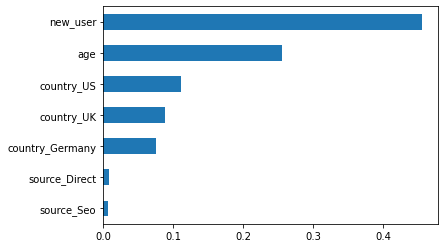

In [25]:
## accuracy went down a little, and let's recheck veriable importance
feat_importances = pd.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot.barh()

In [26]:
## New user is the most important one, even more important than age
# It seems new_user is really important. Source-related dummies don’t seem to matter at all

###### ### conclusion & suggestions:

The site is working very well for young users. Definitely let’s tell marketing to advertise and use channels which are more likely to reach young people.

The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.

Maybe go through the UI and figure out why older users perform so poorly? From ~30 y/o conversion clearly starts dropping. A good actionable metric here is conversion rate for people >=30 yr old. Building a team whose goal is to increase that number would be interesting.

Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, or maybe some payment issue. Given how many users are based in China, fixing this should be a top priority. Huge opportunity.

Product ideas:

Identify segments that perform well, but have low absolute count (like Germany). Then tell marketing to get more of those people

product needs to fix the experience for the bad performing ones

